# Make  my  Trip: ML Challenge
#### Author: Subhojeet Pramanik
     http://github.com/subho406
 


### Table of Contents
---
1. [Import Dependencies](#import)
2. [Load Dataset](#load)
3. [Data pre-processing](#pre)
4. [XGBoost training and optimization](#xgb)
5. [Final Model](#final)
6. [Test prediction](#testpred)

## 1. Import Dependencies
<a id="import"></a>

In [81]:
import sklearn
import numpy as np
import os
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.preprocessing import Imputer
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn import cross_validation, metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from xgboost import plot_importance
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.ensemble import IsolationForest

import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

**Sytem Information**

In [2]:
%load_ext watermark
%watermark -v -n -m -p numpy,pandas,matplotlib,seaborn,sklearn,xgboost

Sun May 27 2018 

CPython 3.6.3
IPython 6.1.0

numpy 1.14.2
pandas 0.20.3
matplotlib 2.1.0
seaborn 0.8.0
sklearn 0.19.1
xgboost 0.71

compiler   : GCC 7.2.0
system     : Linux
release    : 4.13.0-1017-gcp
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


In [3]:
n_jobs=16

## 2. Load the Dataset
<a id="load"></a>

In [4]:
data_dir='./data'
train_file=os.path.join(data_dir,'train.csv')
test_file=os.path.join(data_dir,'test.csv')

In [5]:
train_df=pd.read_csv(train_file)

In [6]:
train_set,test_set=train_test_split(train_df,test_size=0.25,random_state=100)

## 3. Data pre-processing
<a id="pre"></a>

In [7]:
train_df.head()

,id,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P
0,1,b,18.42,10.415,y,p,aa,v,0.125,t,f,0,f,g,120.0,375,1
1,2,a,21.75,11.750,u,g,c,v,0.250,f,f,0,t,g,180.0,0,1
2,3,b,30.17,1.085,y,p,c,v,0.040,f,f,0,f,g,170.0,179,1
3,4,b,22.67,2.540,y,p,c,h,2.585,t,f,0,f,g,0.0,0,0
4,5,a,36.00,1.000,u,g,c,v,2.000,t,t,11,f,g,0.0,456,0


**Output variable distribution**

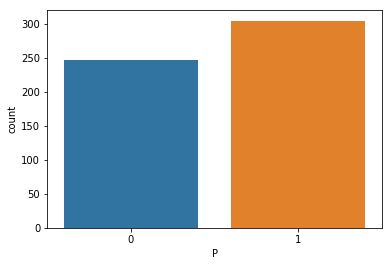

In [8]:
sns.countplot(x='P',data=train_df)

The data-set distribution is not very skewed hence downsampling or upsampling is not required.

**Number of data points null in each column**

In [9]:
train_df.isnull().sum()

id     0
A      8
B      9
C      0
D      5
E      5
F      7
G      7
H      0
I      0
J      0
K      0
L      0
M      0
N     11
O      0
P      0
dtype: int64

In [10]:
categorical_columns=['A','D','E','F','G','I','J','L','M']
continuos_columns=['B','C','H','N','O','K']
feature_names=categorical_columns+continuos_columns

**Impute the training set**

In [11]:
class Encoder:
    """
    An Encoder to encode all categorical and numeric features
    
    """
    def fit(self,train,categorical_columns,continuos_columns):
        df=train.copy()
        self.categorical_columns=categorical_columns
        self.continuos_columns=continuos_columns
        self.continuos_imputer=Imputer()
        modes=df.loc[:,categorical_columns].mode()
        self.categorical_imputer={}
        self.categorical_labeler={}
        for c in categorical_columns:
            self.categorical_imputer[c]=str(modes.loc[:,c][0])   
        df.loc[:,self.categorical_columns]=df.loc[:,self.categorical_columns].fillna(value=self.categorical_imputer)
        for c in categorical_columns:
            self.categorical_labeler[c]=LabelEncoder()
            self.categorical_labeler[c].fit(df.loc[:,c])
            df.loc[:,c]=self.categorical_labeler[c].transform(df.loc[:,c])
        self.continuos_imputer.fit(df.loc[:,continuos_columns])
        self.categorical_encoder=OneHotEncoder()
        self.categorical_encoder.fit(df.loc[:,categorical_columns])
        
    def transform(self,df):
        df=df.copy()
        df.loc[:,self.continuos_columns]=self.continuos_imputer.transform(df.loc[:,self.continuos_columns])
        df.loc[:,self.categorical_columns]=df.loc[:,self.categorical_columns].fillna(value=self.categorical_imputer)
        for c in self.categorical_columns:
            df.loc[:,c]=self.categorical_labeler[c].transform(df.loc[:,c])
        df_cat=self.categorical_encoder.transform(df.loc[:,categorical_columns])
        df_cat=pd.DataFrame(df_cat.toarray())
        df_cont=df.loc[:,continuos_columns]
        df_cont=df_cont.reset_index(drop=True)
        df_encoded=pd.concat([df_cat,df_cont], axis=1,ignore_index=True)
        return df_encoded

In [12]:
encoder=Encoder()
encoder.fit(train_df,categorical_columns,continuos_columns)

In [13]:
X_train=encoder.transform(train_set)
X_test=encoder.transform(test_set)

In [14]:
y_train=train_set['P']
y_test=test_set['P']

**Pairplot of continuos features**

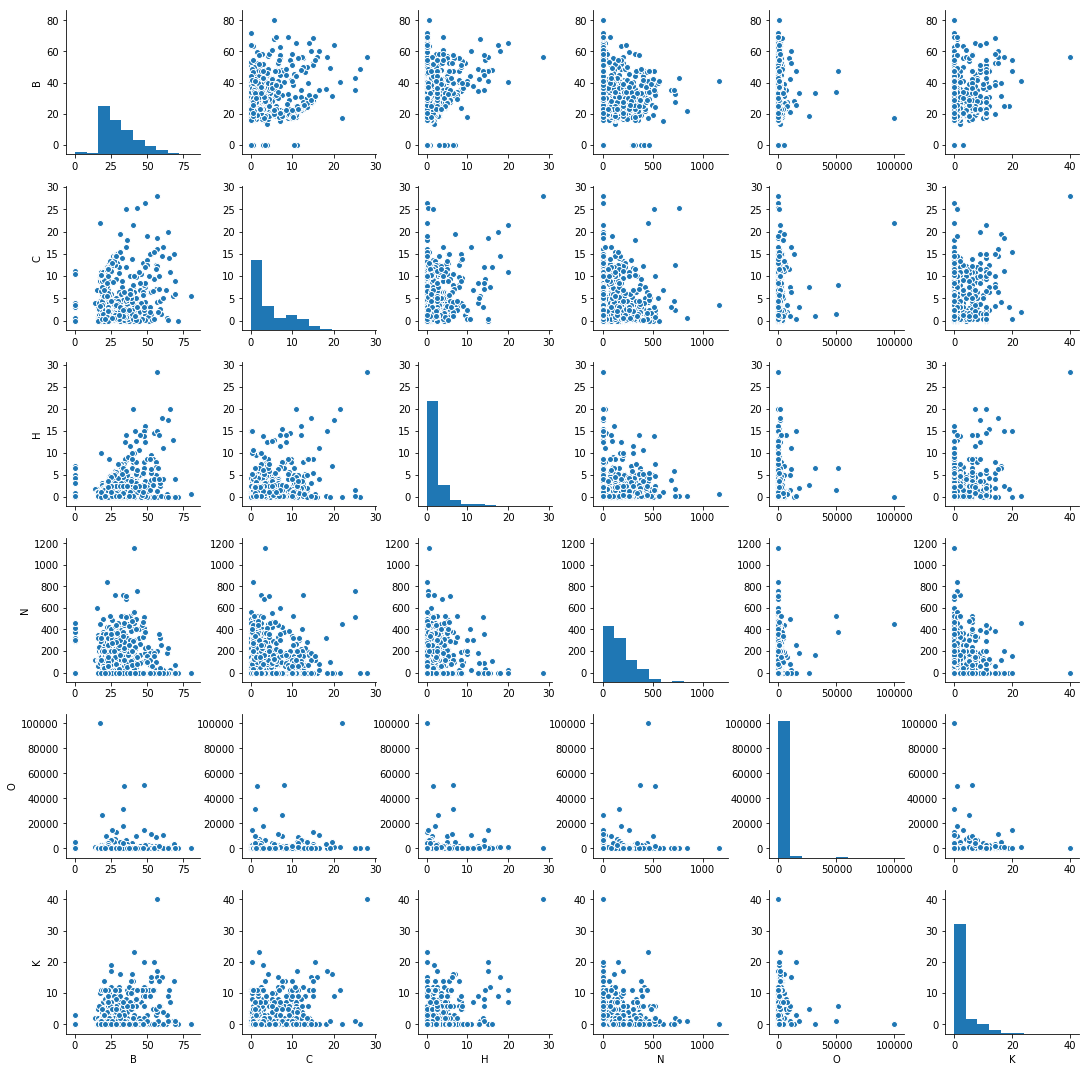

In [15]:
sns.pairplot(train_df.loc[:,continuos_columns].fillna(0))

**Values of categorical columns**

In [16]:
for c in categorical_columns:
    print('Column %s: %s'%(c,str(pd.Series.unique(train_df.loc[:,c]))))

Column A: ['b' 'a' nan]
Column D: ['y' 'u' 'l' nan]
Column E: ['p' 'g' 'gg' nan]
Column F: ['aa' 'c' 'ff' 'd' 'm' 'j' 'i' 'k' 'cc' 'x' 'w' 'e' 'q' nan 'r']
Column G: ['v' 'h' 'ff' 'j' 'bb' 'z' 'n' nan 'o' 'dd']
Column I: ['t' 'f']
Column J: ['f' 't']
Column L: ['f' 't']
Column M: ['g' 's' 'p']


**Let's Normalize the dataset to zero mean and unit variance for the continuos features**

In [17]:
continuos_scaler=StandardScaler()
continuos_scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [18]:
X_train=continuos_scaler.transform(X_train)
X_test=continuos_scaler.transform(X_test)

** Great now we have zero-mean and unit variance. We can probably begin the training process**

## 4. XGBoost Training and Optimization
<a id="xgb"></a>

**Utility function to determine the best number of boosting rounds and for fitting the new model.**

In [19]:
def tunefit(model, X_train, X_test, y_train, y_test, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    '''XGBoost hyper-parameter tuning and report generation

    Parameters
    ----------
        model: A xgboost.sklearn.XGBClassifier object
        dtrain: Dataframe to train the model on
        dtest: Dataframe to cross evaluate the model on
        features: List of features to be used for training
        useTrainCV: Whether to use cross-validation first
        cv_folds: k of k-fold cross-validation
        early_stopping_rounds: rounds to stop after no improvement

    Returns
    -------
        model: trained and tuned XGBoost model
        cv_result: cross-validation history, if useTrainCV is True
    '''

    if useTrainCV:
        print("Training with Cross-Validation")
        xgb_param = model.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train, label=y_train)
        xgtest = xgb.DMatrix(X_test)
        
        print("Begin Cross-validation Grid Search...")
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=model.get_params()['n_estimators'], nfold=cv_folds,
            metrics='map', early_stopping_rounds=early_stopping_rounds)
        
        print("Cross-validation Done. Setting parameters...")
        print("Best n_estimators = {}".format(cvresult.shape[0]))
        model.set_params(n_estimators=cvresult.shape[0])
        
        print("Saving tuned model...")
        joblib.dump(model, "xgb-tuned.pk")
        
    #Fit the modelorithm on the data
    print("Training the model on given parameters...")
    model.fit(X_train, y_train,eval_metric='auc')
    
    print("Saving trained model...")
    joblib.dump(model, "xgb-tuned-trained.pk")
    
    # Predict training set
    print("\nPredicting the train set...")
    dtrain_predictions = model.predict(X_train)
    dtrain_predprob = model.predict_proba(X_train)[:,1]
        
    print("Accuracy : %.4g" % metrics.accuracy_score(y_train, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(y_train, dtrain_predprob))
    
    #Predict on testing data:
    print("Predicting the test set...")
    predprob = model.predict_proba(X_test)[:,1]
    print('AUC Score (Test): %f' % metrics.roc_auc_score(y_test, predprob))
    
    # Generating full report on test set
    print("\nModel Report on Test Set")
    y_pred = model.predict(X_test)
    conf_mat=confusion_matrix(y_test,y_pred, [0,1])
    plot_confusion_matrix(conf_mat,classes=[0,1],
                      title='XGBoost | Confusion Matrix')
    print(classification_report(y_test, y_pred))

    # Feature Importance            
    plot_importance(model)
    plt.show()
    
    if useTrainCV:
        return model, cvresult
    return model

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [20]:
model = XGBClassifier(
        learning_rate = 0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=n_jobs,
        scale_pos_weight=1,
        seed=42,
        silent=False)

Training with Cross-Validation
Begin Cross-validation Grid Search...
Cross-validation Done. Setting parameters...
Best n_estimators = 13
Saving tuned model...
Training the model on given parameters...
Saving trained model...

Predicting the train set...
Accuracy : 0.9251
AUC Score (Train): 0.976240
Predicting the test set...
AUC Score (Test): 0.936065

Model Report on Test Set
Confusion matrix, without normalization


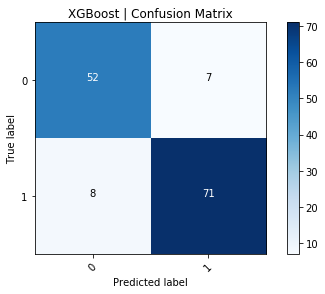

             precision    recall  f1-score   support

          0       0.87      0.88      0.87        59
          1       0.91      0.90      0.90        79

avg / total       0.89      0.89      0.89       138



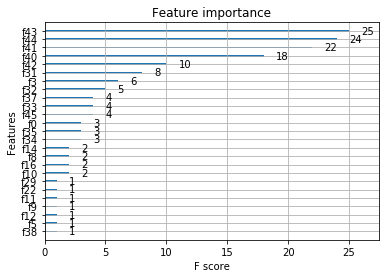

In [21]:
model, cv_result = tunefit(model, X_train, X_test, y_train,y_test,cv_folds=10)

In [22]:
n_estimators = 13

**Tune max depth & min child weight**

In [23]:
param_test1 = {
    'max_depth':range(3,10,1),
    'min_child_weight':range(1,6,1)
    }

In [24]:
search1 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=n_estimators,
                                                  max_depth=5, min_child_weight=1, gamma=0,
                                                  subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=-1,
                                                  scale_pos_weight=1, seed=42),
                        param_grid = param_test1, scoring='precision',
                        verbose=10, n_jobs=1,iid=False, cv=5)

In [25]:
search1.fit(X_train, y_train)

Fitting 5 folds for each of 35 candidates, totalling 175 fits
[CV] max_depth=3, min_child_weight=1 .................................
[CV]  max_depth=3, min_child_weight=1, score=0.8809523809523809, total=   0.0s
[CV] max_depth=3, min_child_weight=1 .................................
[CV]  max_depth=3, min_child_weight=1, score=0.8837209302325582, total=   0.0s
[CV] max_depth=3, min_child_weight=1 .................................
[CV]  max_depth=3, min_child_weight=1, score=0.8604651162790697, total=   0.0s
[CV] max_depth=3, min_child_weight=1 .................................
[CV] ..... max_depth=3, min_child_weight=1, score=0.925, total=   0.0s
[CV] max_depth=3, min_child_weight=1 .................................
[CV] ....... max_depth=3, min_child_weight=1, score=0.9, total=   0.0s
[CV] max_depth=3, min_child_weight=2 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.2s remaining:    0.0s


[CV]  max_depth=3, min_child_weight=2, score=0.8809523809523809, total=   0.0s
[CV] max_depth=3, min_child_weight=2 .................................
[CV]  max_depth=3, min_child_weight=2, score=0.8837209302325582, total=   0.0s
[CV] max_depth=3, min_child_weight=2 .................................
[CV]  max_depth=3, min_child_weight=2, score=0.8409090909090909, total=   0.0s
[CV] max_depth=3, min_child_weight=2 .................................
[CV]  max_depth=3, min_child_weight=2, score=0.8863636363636364, total=   0.0s
[CV] max_depth=3, min_child_weight=2 .................................
[CV]  max_depth=3, min_child_weight=2, score=0.8780487804878049, total=   0.0s
[CV] max_depth=3, min_child_weight=3 .................................
[CV]  max_depth=3, min_child_weight=3, score=0.8809523809523809, total=   0.0s
[CV] max_depth=3, min_child_weight=3 .................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.3s remaining:    0.0s


[CV]  max_depth=3, min_child_weight=3, score=0.8837209302325582, total=   0.0s
[CV] max_depth=3, min_child_weight=3 .................................
[CV]  max_depth=3, min_child_weight=3, score=0.8222222222222222, total=   0.0s
[CV] max_depth=3, min_child_weight=3 .................................
[CV]  max_depth=3, min_child_weight=3, score=0.926829268292683, total=   0.0s
[CV] max_depth=3, min_child_weight=3 .................................
[CV]  max_depth=3, min_child_weight=3, score=0.8837209302325582, total=   0.0s
[CV] max_depth=3, min_child_weight=4 .................................
[CV]  max_depth=3, min_child_weight=4, score=0.8809523809523809, total=   0.0s
[CV] max_depth=3, min_child_weight=4 .................................
[CV]  max_depth=3, min_child_weight=4, score=0.8837209302325582, total=   0.0s
[CV] max_depth=3, min_child_weight=4 .................................
[CV]  max_depth=3, min_child_weight=4, score=0.8222222222222222, total=   0.0s
[CV] max_depth=3, min_

[CV]  max_depth=5, min_child_weight=5, score=0.8863636363636364, total=   0.0s
[CV] max_depth=5, min_child_weight=5 .................................
[CV]  max_depth=5, min_child_weight=5, score=0.8695652173913043, total=   0.0s
[CV] max_depth=5, min_child_weight=5 .................................
[CV]  max_depth=5, min_child_weight=5, score=0.8043478260869565, total=   0.0s
[CV] max_depth=5, min_child_weight=5 .................................
[CV]  max_depth=5, min_child_weight=5, score=0.926829268292683, total=   0.0s
[CV] max_depth=5, min_child_weight=5 .................................
[CV]  max_depth=5, min_child_weight=5, score=0.8863636363636364, total=   0.0s
[CV] max_depth=6, min_child_weight=1 .................................
[CV]  max_depth=6, min_child_weight=1, score=0.8888888888888888, total=   0.1s
[CV] max_depth=6, min_child_weight=1 .................................
[CV]  max_depth=6, min_child_weight=1, score=0.8695652173913043, total=   0.1s
[CV] max_depth=6, min_

[CV]  max_depth=8, min_child_weight=1, score=0.8837209302325582, total=   0.1s
[CV] max_depth=8, min_child_weight=1 .................................
[CV]  max_depth=8, min_child_weight=1, score=0.8809523809523809, total=   0.1s
[CV] max_depth=8, min_child_weight=1 .................................
[CV]  max_depth=8, min_child_weight=1, score=0.8604651162790697, total=   0.1s
[CV] max_depth=8, min_child_weight=2 .................................
[CV]  max_depth=8, min_child_weight=2, score=0.8888888888888888, total=   0.0s
[CV] max_depth=8, min_child_weight=2 .................................
[CV]  max_depth=8, min_child_weight=2, score=0.8695652173913043, total=   0.1s
[CV] max_depth=8, min_child_weight=2 .................................
[CV]  max_depth=8, min_child_weight=2, score=0.8409090909090909, total=   0.0s
[CV] max_depth=8, min_child_weight=2 .................................
[CV]  max_depth=8, min_child_weight=2, score=0.8863636363636364, total=   0.0s
[CV] max_depth=8, min

[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:    7.8s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=13,
       n_jobs=1, nthread=-1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=1,
       param_grid={'max_depth': range(3, 10), 'min_child_weight': range(1, 6)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='precision', verbose=10)

In [26]:
search1.grid_scores_, search1.best_params_, search1.best_score_

([mean: 0.89003, std: 0.02153, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.87400, std: 0.01678, params: {'max_depth': 3, 'min_child_weight': 2},
  mean: 0.87949, std: 0.03334, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.87059, std: 0.02714, params: {'max_depth': 3, 'min_child_weight': 4},
  mean: 0.87278, std: 0.03343, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.87712, std: 0.01501, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: 0.86047, std: 0.02569, params: {'max_depth': 4, 'min_child_weight': 2},
  mean: 0.86674, std: 0.01938, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: 0.85317, std: 0.02741, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: 0.87411, std: 0.04000, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: 0.89141, std: 0.01182, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.87543, std: 0.01929, params: {'max_depth': 5, 'min_child_weight': 2},
  mean: 0.86235, std: 0.01551, params: {

In [27]:
max_depth = 5
min_child_weight = 1

In [28]:
model = XGBClassifier(
        learning_rate=0.1,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=n_jobs,
        scale_pos_weight=1,
        seed=42,
        silent=False)

Training with Cross-Validation
Begin Cross-validation Grid Search...
Cross-validation Done. Setting parameters...
Best n_estimators = 13
Saving tuned model...
Training the model on given parameters...
Saving trained model...

Predicting the train set...
Accuracy : 0.9251
AUC Score (Train): 0.976240
Predicting the test set...
AUC Score (Test): 0.936065

Model Report on Test Set
Confusion matrix, without normalization


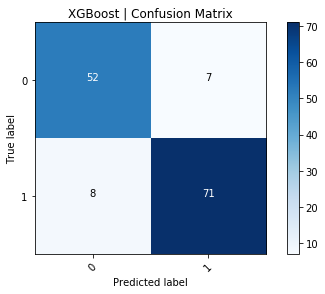

             precision    recall  f1-score   support

          0       0.87      0.88      0.87        59
          1       0.91      0.90      0.90        79

avg / total       0.89      0.89      0.89       138



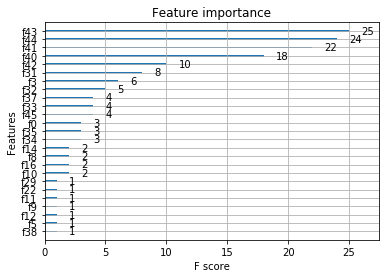

In [29]:
model = tunefit(model, X_train, X_test, y_train,y_test,cv_folds=10)

**Fix Gamma**

In [30]:
param_test3 = {
    'gamma':[i/10.0 for i in range(0,5)]
}

In [31]:
search2 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=n_estimators, max_depth=max_depth,
                                        min_child_weight=min_child_weight, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=-1, scale_pos_weight=1,seed=27), 
                       param_grid = param_test3, scoring='precision',n_jobs=1,iid=False, cv=5)


In [32]:
search2.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=13,
       n_jobs=1, nthread=-1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=1,
       param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='precision', verbose=0)

In [33]:
search2.grid_scores_, search2.best_params_, search2.best_score_

([mean: 0.86447, std: 0.02314, params: {'gamma': 0.0},
  mean: 0.86056, std: 0.02506, params: {'gamma': 0.1},
  mean: 0.86056, std: 0.02506, params: {'gamma': 0.2},
  mean: 0.85975, std: 0.02631, params: {'gamma': 0.3},
  mean: 0.85975, std: 0.02631, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 0.8644674244977582)

In [34]:
gamma=0.0

In [35]:
model = XGBClassifier(
        learning_rate=0.1,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=n_jobs,
        scale_pos_weight=1,
        seed=42,
        silent=False)

Training with Cross-Validation
Begin Cross-validation Grid Search...
Cross-validation Done. Setting parameters...
Best n_estimators = 13
Saving tuned model...
Training the model on given parameters...
Saving trained model...

Predicting the train set...
Accuracy : 0.9251
AUC Score (Train): 0.976240
Predicting the test set...
AUC Score (Test): 0.936065

Model Report on Test Set
Confusion matrix, without normalization


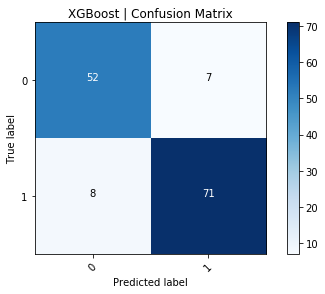

             precision    recall  f1-score   support

          0       0.87      0.88      0.87        59
          1       0.91      0.90      0.90        79

avg / total       0.89      0.89      0.89       138



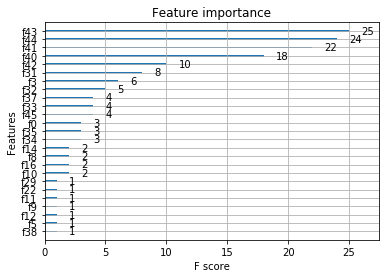

In [36]:
model = tunefit(model, X_train, X_test, y_train,y_test,cv_folds=10)

**Tune subsample and colsample_bytree**

In [37]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=n_estimators, max_depth=max_depth,
 min_child_weight=min_child_weight, gamma=gamma, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='precision',n_jobs=1,iid=False, cv=5)
gsearch4.fit(X_train, y_train)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.89142, std: 0.03636, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.87968, std: 0.03203, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.89391, std: 0.03606, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.89035, std: 0.02989, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.88517, std: 0.03685, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.87928, std: 0.02775, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.88501, std: 0.04197, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.88961, std: 0.02906, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.87358, std: 0.04277, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.88088, std: 0.03462, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.86447, std: 0.02314, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.87675, std: 0.02935, params: {'colsample_bytree': 0.8, 'subsample'

In [38]:
param_test5 = {
 'subsample':[i/100.0 for i in range(50,70,5)],
 'colsample_bytree':[i/100.0 for i in range(70,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=n_estimators, max_depth=max_depth,
 min_child_weight=min_child_weight, gamma=gamma, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='precision',n_jobs=1,iid=False, cv=5)
gsearch5.fit(X_train, y_train)
gsearch5.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.90569, std: 0.04486, params: {'colsample_bytree': 0.7, 'subsample': 0.5},
  mean: 0.89623, std: 0.03779, params: {'colsample_bytree': 0.7, 'subsample': 0.55},
  mean: 0.88517, std: 0.03685, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.88423, std: 0.03626, params: {'colsample_bytree': 0.7, 'subsample': 0.65},
  mean: 0.89293, std: 0.03592, params: {'colsample_bytree': 0.75, 'subsample': 0.5},
  mean: 0.89623, std: 0.03779, params: {'colsample_bytree': 0.75, 'subsample': 0.55},
  mean: 0.87792, std: 0.03749, params: {'colsample_bytree': 0.75, 'subsample': 0.6},
  mean: 0.87987, std: 0.03538, params: {'colsample_bytree': 0.75, 'subsample': 0.65},
  mean: 0.88188, std: 0.03470, params: {'colsample_bytree': 0.8, 'subsample': 0.5},
  mean: 0.87381, std: 0.02914, params: {'colsample_bytree': 0.8, 'subsample': 0.55},
  mean: 0.87358, std: 0.04277, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.87278, std: 0.03283, params: {'colsample_bytree': 0.8, 's

In [39]:
colsample_bytree= 0.6
subsample=0.8

In [40]:
model = XGBClassifier(
        learning_rate=0.1,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        objective= 'binary:logistic',
        nthread=n_jobs,
        scale_pos_weight=1,
        seed=42,
        silent=False)

Training with Cross-Validation
Begin Cross-validation Grid Search...
Cross-validation Done. Setting parameters...
Best n_estimators = 13
Saving tuned model...
Training the model on given parameters...
Saving trained model...

Predicting the train set...
Accuracy : 0.9251
AUC Score (Train): 0.977853
Predicting the test set...
AUC Score (Test): 0.933920

Model Report on Test Set
Confusion matrix, without normalization


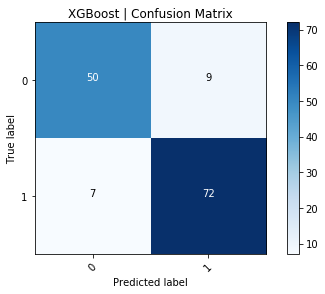

             precision    recall  f1-score   support

          0       0.88      0.85      0.86        59
          1       0.89      0.91      0.90        79

avg / total       0.88      0.88      0.88       138



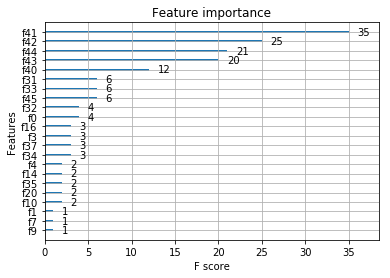

In [41]:
model = tunefit(model, X_train, X_test, y_train,y_test,cv_folds=10)

**Tune Regularization parameters**

In [42]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=n_estimators, max_depth=max_depth,
 min_child_weight=min_child_weight, gamma=gamma,subsample=subsample, colsample_bytree=colsample_bytree,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='precision',n_jobs=1,iid=False, cv=5)
gsearch6.fit(X_train, y_train)
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: 0.89391, std: 0.03606, params: {'reg_alpha': 1e-05},
  mean: 0.89391, std: 0.03606, params: {'reg_alpha': 0.01},
  mean: 0.88593, std: 0.03475, params: {'reg_alpha': 0.1},
  mean: 0.88565, std: 0.03255, params: {'reg_alpha': 1},
  mean: 0.00000, std: 0.00000, params: {'reg_alpha': 100}],
 {'reg_alpha': 1e-05},
 0.8939091254947327)

In [43]:
reg_alpha=1e-05

In [44]:
model = XGBClassifier(
        learning_rate=0.1,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        objective= 'binary:logistic',
        nthread=n_jobs,
        scale_pos_weight=1,
        seed=42,
        reg_alpha=reg_alpha,
        silent=False)

Training with Cross-Validation
Begin Cross-validation Grid Search...
Cross-validation Done. Setting parameters...
Best n_estimators = 13
Saving tuned model...
Training the model on given parameters...
Saving trained model...

Predicting the train set...
Accuracy : 0.9251
AUC Score (Train): 0.977853
Predicting the test set...
AUC Score (Test): 0.933920

Model Report on Test Set
Confusion matrix, without normalization


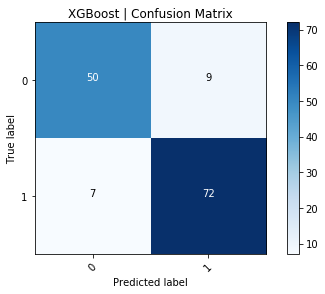

             precision    recall  f1-score   support

          0       0.88      0.85      0.86        59
          1       0.89      0.91      0.90        79

avg / total       0.88      0.88      0.88       138



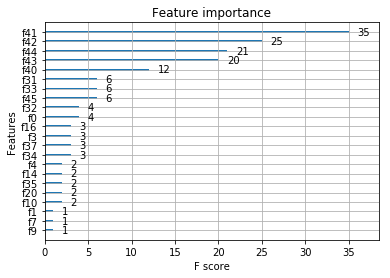

In [45]:
model = tunefit(model, X_train, X_test, y_train,y_test,cv_folds=10)

**Reduce the learning rate**

In [46]:
model = XGBClassifier(
        learning_rate=0.01,
        n_estimators=5000,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        objective= 'binary:logistic',
        nthread=n_jobs,
        scale_pos_weight=1,
        seed=42,
        reg_alpha=reg_alpha,
        silent=False)

Training with Cross-Validation
Begin Cross-validation Grid Search...
Cross-validation Done. Setting parameters...
Best n_estimators = 74
Saving tuned model...
Training the model on given parameters...
Saving trained model...

Predicting the train set...
Accuracy : 0.93
AUC Score (Train): 0.977076
Predicting the test set...
AUC Score (Test): 0.942073

Model Report on Test Set
Confusion matrix, without normalization


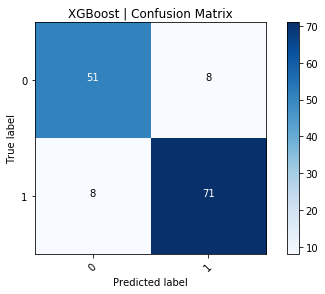

             precision    recall  f1-score   support

          0       0.86      0.86      0.86        59
          1       0.90      0.90      0.90        79

avg / total       0.88      0.88      0.88       138



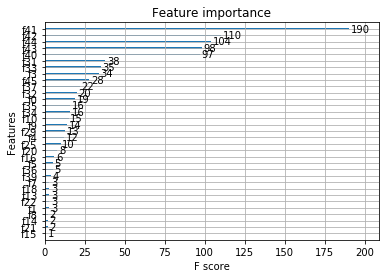

In [47]:
model = tunefit(model, X_train, X_test, y_train,y_test,cv_folds=10)

In [48]:
learning_rate=0.01
n_estimators=74

## 5. Final Model
<a id="final"></a>

In [49]:
model = XGBClassifier(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        objective= 'binary:logistic',
        nthread=n_jobs,
        scale_pos_weight=1,
        seed=42,
        reg_alpha=reg_alpha,
        silent=False)

Training with Cross-Validation
Begin Cross-validation Grid Search...
Cross-validation Done. Setting parameters...
Best n_estimators = 74
Saving tuned model...
Training the model on given parameters...
Saving trained model...

Predicting the train set...
Accuracy : 0.93
AUC Score (Train): 0.977076
Predicting the test set...
AUC Score (Test): 0.942073

Model Report on Test Set
Confusion matrix, without normalization


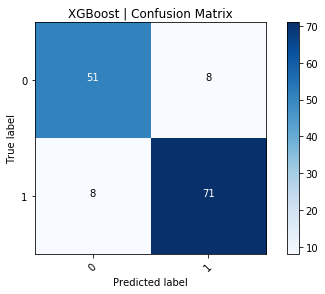

             precision    recall  f1-score   support

          0       0.86      0.86      0.86        59
          1       0.90      0.90      0.90        79

avg / total       0.88      0.88      0.88       138



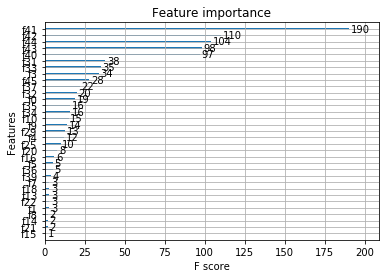

In [50]:
model = tunefit(model, X_train, X_test, y_train,y_test,cv_folds=10)

**Train using entire train set **

**Outlier Detection**

In [122]:
encoder=Encoder()
encoder.fit(train_df,categorical_columns,continuos_columns)

In [123]:
train_encoded=encoder.transform(train_df)

In [124]:
scaler=StandardScaler()
scaler.fit(train_encoded)
X_full=scaler.transform(train_encoded)

In [125]:
y_full=train_df['P']

In [126]:
outlier_model=IsolationForest()
outlier_model.fit(X_full,y_full)

IsolationForest(bootstrap=False, contamination=0.1, max_features=1.0,
        max_samples='auto', n_estimators=100, n_jobs=1, random_state=None,
        verbose=0)

In [127]:
outliers=outlier_model.predict(X_full)==-1

In [128]:
X_full=X_full[outliers==False]
y_full=y_full[outliers==False]

In [129]:
model = XGBClassifier(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        objective= 'binary:logistic',
        nthread=n_jobs,
        scale_pos_weight=1,
        seed=42,
        reg_alpha=reg_alpha,
        silent=False)

In [130]:
model.fit(X_full,y_full)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.0, learning_rate=0.01,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=74, n_jobs=1, nthread=16, objective='binary:logistic',
       random_state=0, reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=False, subsample=0.8)

## 6. Test Prediction
<a id="testpred"></a>

In [131]:
test_df=pd.read_csv(test_file)

In [132]:
test_encoded=encoder.transform(test_df)

In [133]:
X_test=scaler.transform(test_encoded)

In [134]:
test_pred=model.predict(X_test)

In [135]:
submission_dict={'id':test_df['id'],'P':test_pred}
submission_df=pd.DataFrame(submission_dict,columns=['id','P'])

In [136]:
submission_df.to_csv('predictions/submission.csv',index=None)